In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
import multiprocessing as mp
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import poisson
from scipy.optimize import curve_fit
import astropy.io.fits as fits

 ### Trabalho 2 
    - Fotometria de abertura em 8 frames de uma ocultação estelar.
    - Intuito de comparar curvas de luz -> faz-se necessário adquirir a medida do fluxo de cada frame
    

 ##### Perguntas a serem respondidas durante a análise:
    
    1. Qual o centróide (x,y) da estrela alvo?
    2. Qual a melhor abertura para fazermos a fotometria do nosso alvo?

In [2]:
im_data = fits.getdata('0859.fits')

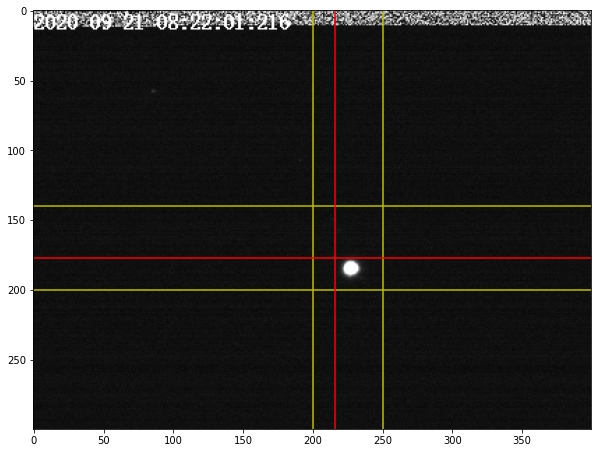

In [3]:
plt.figure(figsize=[10, 10])
plt.axvline(200, color='y')
plt.axvline(250, color='y')
plt.axhline(140, color='y')
plt.axhline(200, color='y')
plt.axvline(216, color='r') #Estrela alvo
plt.axhline(177, color='r') #Estrela alvo
#plt.axvline(261, color='b') #Estrela comparação
#plt.axhline(279, color='b') #Estrela comparação
plt.imshow(im_data, cmap='gray')
plt.show()

In [4]:
im_hd = fits.getheader('0859.fits')
im_hd

SIMPLE  =                    T / C# FITS: 9/21/2020 4:22:01 AM                  
BITPIX  =                   16                                                  
NAXIS   =                    2 / Dimensionality                                 
NAXIS1  =                  400                                                  
NAXIS2  =                  300                                                  
OBSLAT  =            44.261345 /                                                
GPSSTAT = 'Locked  '           /                                                
DATE-END= '2020-09-21T08:22:01.3100000' / System Clock-Frame Grabbed            
DATE-OBS= '2020-09-21T08:22:01.2169755' / GPS-Start Exp                         
SWCREATE= 'SharpCap'           /                                                
CCD-TEMP=                 -7.1 /                                                
YBINNING=                    2 /                                                
YPIXSZ  =      5.86000013351

In [5]:
time = im_hd.get('DATE-OBS')
print(time)

2020-09-21T08:22:01.2169755


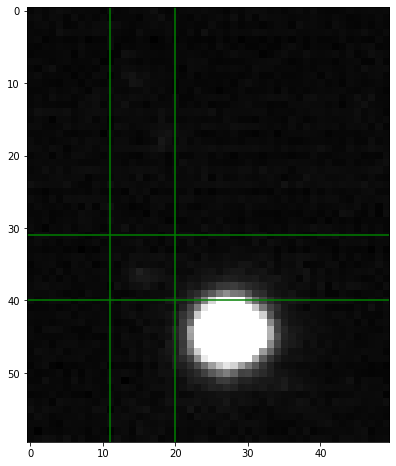

In [6]:
new_data = im_data[140:200,200:250]
plt.figure(figsize=[8, 8])
plt.imshow(new_data, cmap='gray')
#plt.axvline(15, color='r')
#plt.axhline(36, color='r')
plt.axvline(11, color='g')
plt.axvline(20, color='g')
plt.axhline(40, color='g')
plt.axhline(31, color='g')
plt.show()

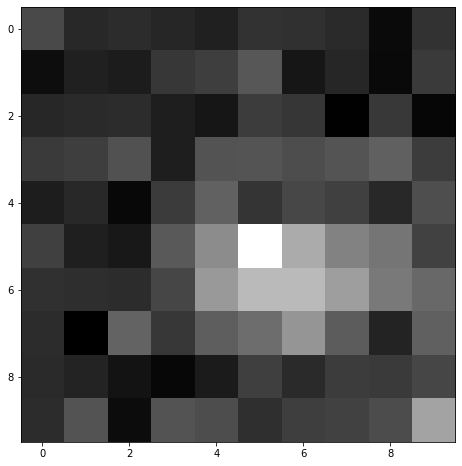

In [7]:
im_alvo = new_data[30:47,10:21] # Imagem recortada de forma a vizualizar a abertura mais completamente. Usar essa variavel para fazer a fotometria torna o brilho de Urano relevante demais na contagem, desviando o centro.
#alvo = new_data[30:44,10:20] # Imagem da estrela alvo mais isolada possivel de Urano. Descartado temporariamente pois ainda é muito afetada por Urano o que afeta o calculo do centro.
alvo = new_data[31:41,10:20] # Imagem da estrela alvo mais isolada possível de Urano. Este recorte limita muito o anel do fundo de ceu.
plt.figure(figsize=[8, 8])
plt.imshow(alvo, cmap='gray')
#plt.axvline(15, color='r')
#plt.axhline(36, color='r')
#plt.axvline(61, color='g')
#plt.axhline(79, color='g')
plt.show()

In [8]:
def momento(data):
    '''
    Função que devolve o fotocentro da imagem utilizando o método do momento.
    '''
    I_i = np.sum(data, axis=0)
    I_j = np.sum(data, axis=1)
    Ii_mean = np.sum(I_i)/len(I_i)
    Ij_mean = np.sum(I_j)/len(I_j)

    x_i = np.arange(data.shape[1])
    y_j = np.arange(data.shape[0])
    mask_i = (I_i - Ii_mean) > 0
    mask_j = (I_j - Ij_mean) > 0

    xc = np.sum((I_i - Ii_mean)[mask_i]*x_i[mask_i])/np.sum((I_i - Ii_mean)[mask_i])
    yc = np.sum((I_j - Ij_mean)[mask_j]*y_j[mask_j])/np.sum((I_j - Ij_mean)[mask_j])
    return xc, yc

In [9]:
xc, yc = momento(alvo)
print(xc, yc)

5.720637657994912 5.711067277439968


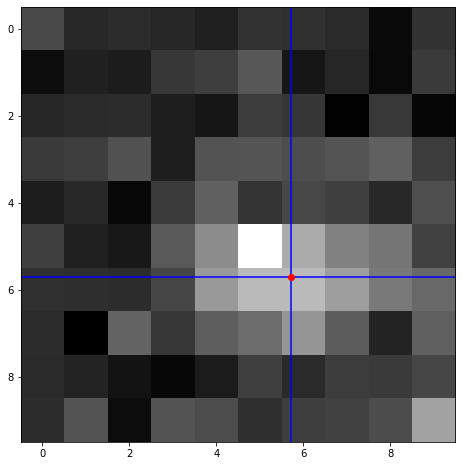

In [10]:
plt.figure(figsize=[8, 8])
plt.imshow(alvo, cmap='gray', 
          # vmin=alvo.mean()-1000, vmax=alvo.mean()+1000
          )

plt.axhline(yc, color='blue')
plt.axvline(xc, color='blue')
plt.plot(xc, yc, 'ro')

plt.show()

 - Agora determinamos os pixels que iremos somar

In [11]:
y = np.arange(alvo.shape[0])
x = np.arange(alvo.shape[1])

x, y = np.meshgrid(x, y)

In [12]:
abertura = 3

mask = np.sqrt((x - xc)**2 + (y - yc)**2) < abertura

image_copy = np.copy(alvo.astype('float64')) # Puramente para ilustração. Continuamos usando a variavel alvo pois temos os valores do xc,yc referentes a essa imagem. Usamos a imagem im_alvo apenas como mapa de fundo pois ela é maior e oferece melhor perspectiva.
image_copy[~mask] = np.nan  # Puramente para ilustração

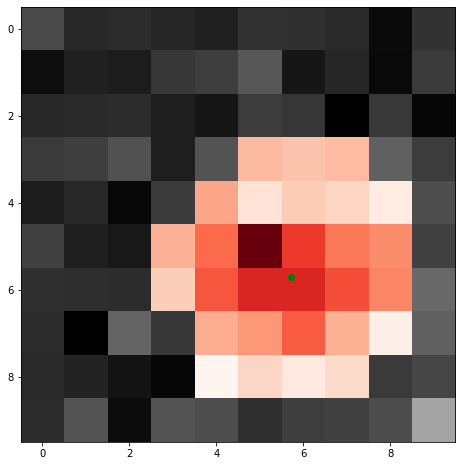

In [13]:
plt.figure(figsize=[8, 8])
plt.imshow(alvo, cmap='gray', #Agora é conveniente utilizar esse recorte para visualizarmos a abertura de forma completa.
          #vmin=alvo.mean()-100, 
          #vmax=alvo.mean()+100
          )

plt.imshow(image_copy, cmap='Reds', 
          #vmin=im_data.mean()-100, 
          #vmax=im_data.mean()+100
          )
plt.plot(xc, yc, 'go')
plt.show()

In [14]:
fluxo = np.sum(alvo[mask])
print(fluxo)

npix = len(alvo[mask])
print(npix)

172955
29


- Queremos indentificar a melhor abertura

In [15]:
fluxos = np.array([])
abertura = np.arange(1,8)

for i in abertura:
    mask = np.sqrt((x - xc)**2 + (y - yc)**2) < i
    fluxos = np.append(fluxos, np.sum(alvo[mask]))

Text(0.5, 0, 'Fuxo [contagens]')

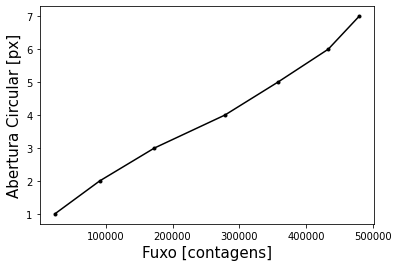

In [16]:
plt.plot(fluxos, abertura, 'k.-')
plt.ylabel('Abertura Circular [px]', fontsize=15)
plt.xlabel('Fuxo [contagens]', fontsize=15)

In [17]:
snr = fluxo/np.sqrt(fluxo)

print('S/N:', snr)

S/N: 415.87858805184953


 - Determinando o fundo de céu...

In [18]:
outer_ring = 5
inner_ring = 3

mask_sky = ((np.sqrt((x - xc)**2 + (y - yc)**2) < outer_ring) 
           *(np.sqrt((x - xc)**2 + (y - yc)**2) > inner_ring))


image_sky = np.copy(alvo.astype('float64')) # Puramente para ilustração
image_sky[~mask_sky] = np.nan  # Puramente para ilustração

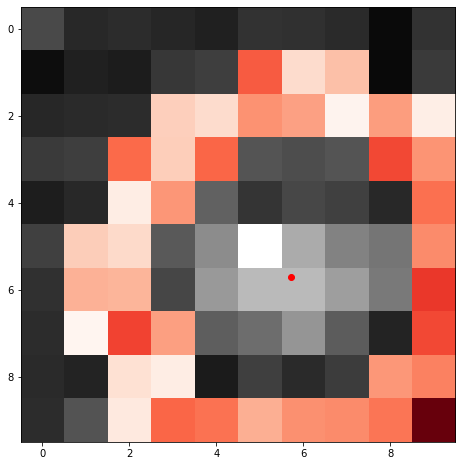

In [19]:
plt.figure(figsize=[8, 8])
plt.imshow(alvo, cmap='gray')
plt.imshow(image_sky, cmap='Reds', 
           #alpha=1.0
          )
plt.plot(xc, yc, 'ro')
plt.show()

In [20]:
flux_sky = np.sum(alvo[mask_sky])
print('Flux do céu:', flux_sky)

npix_sky = len(alvo[mask_sky])
print('Número de pixeis:', npix_sky)
print('\n')
print('Distribuição do Fundo do céu:' + 
      '{:.2f} +/- {:.2f}'.format(alvo[mask_sky].mean(),
                                 alvo[mask_sky].std()))

Flux do céu: 184388
Número de pixeis: 40


Distribuição do Fundo do céu:4609.70 +/- 930.11


In [21]:
fluxo_correto = fluxo - npix*alvo[mask_sky].mean()

snr = (fluxo_correto/np.sqrt((fluxo_correto + 
       npix*alvo[mask_sky].mean())))

print('S/N:', snr) #Realista!

S/N: 94.43549422434697


 - Agora podemos analisar a melhor abertura possivel

In [22]:
fluxos = np.array([])
npixs = np.array([])

abertura = np.arange(1,8)
for i in abertura:
    mask = np.sqrt((x - xc)**2 + (y - yc)**2) < i
    fluxos = np.append(fluxos, np.sum(alvo[mask]))
    npixs  = np.append(npixs, len(alvo[mask]))

    
fluxos_new = fluxos - npixs*alvo[mask_sky].mean()

snr = fluxos_new/np.sqrt(fluxos_new + 
                         npixs*alvo[mask_sky].mean())

 - Usarei abertura 2 pois é a melhor abertura, na média, entre os frames

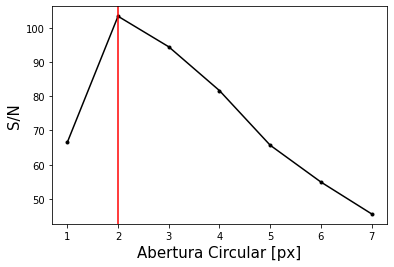

In [23]:
plt.plot(abertura, snr, 'k.-')
plt.xlabel('Abertura Circular [px]', fontsize=15)
plt.ylabel('S/N', fontsize=15)
plt.axvline(2, color='r')
#plt.axhline(587.83, color = 'g')
plt.show()

In [24]:
abertura = 2

mask = np.sqrt((x - xc)**2 + (y - yc)**2) < abertura

image_copy = np.copy(alvo.astype('float64')) # Puramente para ilustração
image_copy[~mask] = np.nan  # Puramente para ilustração

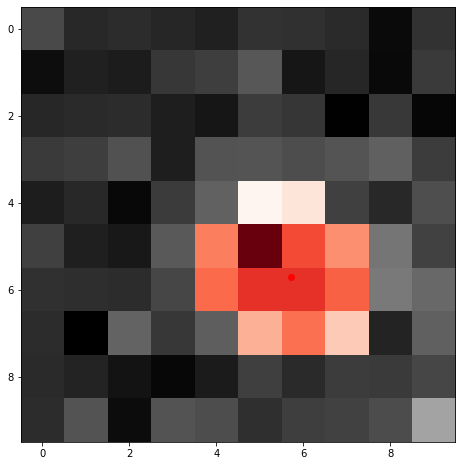

In [25]:
plt.figure(figsize=[8, 8])
plt.imshow(alvo, cmap='gray', 
          #vmin=im_data.mean()-100, 
          #vmax=im_data.mean()+100
          )

plt.imshow(image_copy, cmap='Reds', 
          #vmin=im_data.mean()-100, 
          #vmax=im_data.mean()+100
        )
plt.plot(xc, yc, 'ro')
plt.show()

In [26]:
fluxo = np.sum(alvo[mask])
print(fluxo)

npix = len(alvo[mask])
print(npix)

91125
13


In [27]:
flux_sky = np.sum(alvo[mask_sky])
print('Flux do céu:', flux_sky)

npix_sky = len(alvo[mask_sky])
print('Número de pixeis:', npix_sky)
print('\n')
print('Distribuição do Fundo do céu:' + 
      '{:.2f} +/- {:.2f}'.format(alvo[mask_sky].mean(),
                                 alvo[mask_sky].std()))

Flux do céu: 184388
Número de pixeis: 40


Distribuição do Fundo do céu:4609.70 +/- 930.11


In [28]:
fluxo_correto = fluxo - npix*alvo[mask_sky].mean()

snr = (fluxo_correto/np.sqrt((fluxo_correto + 
       npix*alvo[mask_sky].mean())))

print('S/N:', snr) #Realista!
print('Fluxo do alvo: ', fluxo_correto)

S/N: 103.35238699736028
Fluxo do alvo:  31198.9


 - Calibrador

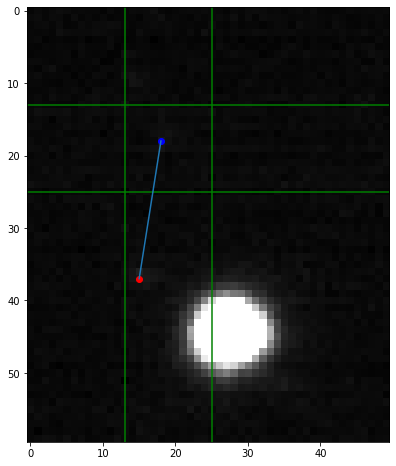

In [29]:
new_data = im_data[140:200,200:250]
plt.figure(figsize=[8, 8])
plt.imshow(new_data, cmap='gray')
#plt.axvline(15, color='r')
#plt.axhline(36, color='r')
plt.axvline(13, color='g')
plt.axvline(25, color='g')
plt.axhline(25, color='g')
plt.axhline(13, color='g')

## Alvo
plt.plot(15, 37, 'ro')
##Calibrador
plt.plot(18, 18, 'bo')

## Distancia entre eles
#plt.plot([1, 10], [1, 10]) irá traçar uma reta ligando os pontos (1,1) e (10,10)
plt.plot([15,18],[37,18])

plt.show()

In [30]:
def reta_entre_pts(xa,xb,ya,yb):
    return np.sqrt((xb-xa)**2 + (yb - ya)**2)
print('Distancia entre Titania e Estrela alvo + Umbriel: ',reta_entre_pts(15,18,37,18))

Distancia entre Titania e Estrela alvo + Umbriel:  19.235384061671343


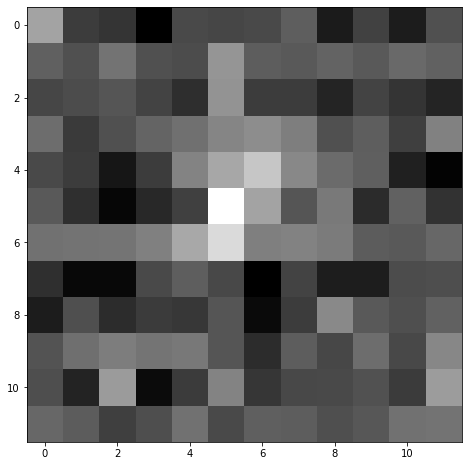

In [31]:
cal = new_data[13:25,13:25] # Imagem do calibrador -> Titania
plt.figure(figsize=[8, 8])
plt.imshow(cal, cmap='gray')
plt.show()

In [32]:
xc, yc = momento(cal)
print(xc, yc)

5.373759541984733 5.421428737511916


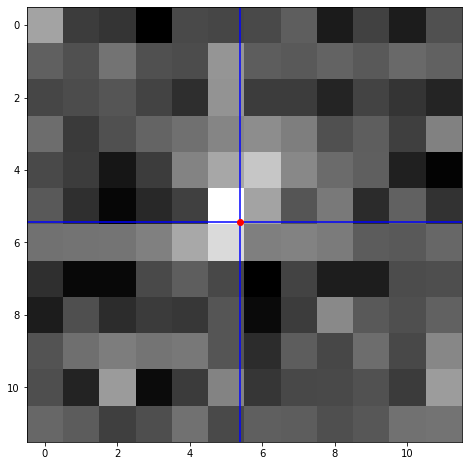

In [33]:
plt.figure(figsize=[8, 8])
plt.imshow(cal, cmap='gray')
plt.axhline(yc, color='blue')
plt.axvline(xc, color='blue')
plt.plot(xc, yc, 'ro')
plt.show()

In [34]:
y = np.arange(cal.shape[0])
x = np.arange(cal.shape[1])

x, y = np.meshgrid(x, y)

In [35]:
outer_ring = 5
inner_ring = 3

mask_sky = ((np.sqrt((x - xc)**2 + (y - yc)**2) < outer_ring) 
           *(np.sqrt((x - xc)**2 + (y - yc)**2) > inner_ring))


image_sky = np.copy(cal.astype('float64')) # Puramente para ilustração
image_sky[~mask_sky] = np.nan  # Puramente para ilustração

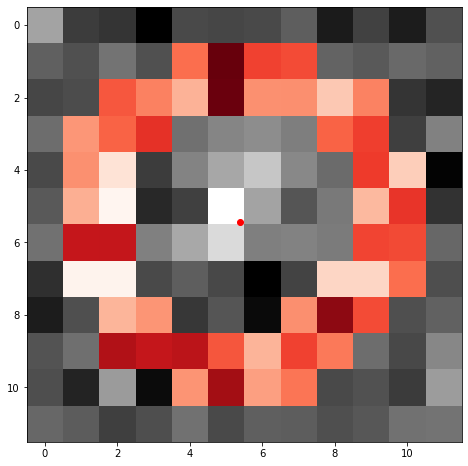

In [36]:
plt.figure(figsize=[8, 8])
plt.imshow(cal, cmap='gray')
plt.imshow(image_sky, cmap='Reds', 
           #alpha=1.0
          )
plt.plot(xc, yc, 'ro')
plt.show()

In [37]:
flux_sky = np.sum(cal[mask_sky])
print('Flux do céu:', flux_sky)

npix_sky = len(cal[mask_sky])
print('Número de pixeis:', npix_sky)
print('\n')
print('Distribuição do Fundo do céu:' + 
      '{:.2f} +/- {:.2f}'.format(cal[mask_sky].mean(),
                                 cal[mask_sky].std()))

Flux do céu: 219131
Número de pixeis: 50


Distribuição do Fundo do céu:4382.62 +/- 647.48


In [38]:
abertura = 2 # Sempre usarei essa abertura pois é a melhor, na média, entre os frames.

mask = np.sqrt((x - xc)**2 + (y - yc)**2) < abertura

image_copy = np.copy(cal.astype('float64')) # Puramente para ilustração
image_copy[~mask] = np.nan  # Puramente para ilustração

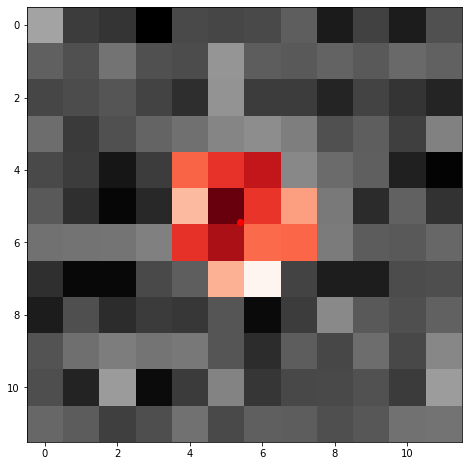

In [39]:
plt.figure(figsize=[8, 8])
plt.imshow(cal, cmap='gray', 
          #vmin=im_data.mean()-100, 
          #vmax=im_data.mean()+100
          )

plt.imshow(image_copy, cmap='Reds', 
          #vmin=im_data.mean()-100, 
          #vmax=im_data.mean()+100
        )
plt.plot(xc, yc, 'ro')
plt.show()

In [40]:
fluxo = np.sum(cal[mask])
print(fluxo)

npix = len(cal[mask])
print(npix)

72022
13


In [41]:
flux_sky = np.sum(cal[mask_sky])
print('Flux do céu:', flux_sky)

npix_sky = len(cal[mask_sky])
print('Número de pixeis:', npix_sky)
print('\n')
print('Distribuição do Fundo do céu:' + 
      '{:.2f} +/- {:.2f}'.format(cal[mask_sky].mean(),
                                 cal[mask_sky].std()))

Flux do céu: 219131
Número de pixeis: 50


Distribuição do Fundo do céu:4382.62 +/- 647.48


In [42]:
fluxo_cal = fluxo - npix*cal[mask_sky].mean()

snr = (fluxo_cal/np.sqrt((fluxo_cal + 
       npix*cal[mask_sky].mean())))

print('S/N do Calibrador:', snr) #Realista!
print('Fluxo do Calibrador: ', fluxo_cal)

S/N do Calibrador: 56.07179539888725
Fluxo do Calibrador:  15047.940000000002


In [43]:
flux_ratio = 31198.9/15047.94
flux_ratio

2.0733003985927643